# Import Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objects as go

from tapy import Indicators

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, 
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix
)

import xgboost
from xgboost import XGBClassifier

from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import to_categorical

# D1 Timeframe

In [2]:
# read in 2019 full year 1 hour timeframe price data
df_d1_feature = pd.read_csv('../data/df_d1_feature.csv', index_col=0)
df_d1_feature.index = pd.to_datetime(df_d1_feature.index)
df_d1_feature = df_d1_feature.dropna()
df_d1_feature.head()

,open,high,low,close,results,day_of_wk,shift_01,close_shift_01_dist,shift_02,close_shift_02_dist,shift_03,close_shift_03_dist,shift_05,close_shift_05_dist,shift_08,close_shift_08_dist,shift_13,close_shift_13_dist,shift_21,close_shift_21_dist,shift_34,close_shift_34_dist,shift_55,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,sma_03,close_sma_03_dist,sma_05,close_sma_05_dist,sma_08,close_sma_08_dist,sma_13,close_sma_13_dist,sma_21,close_sma_21_dist,sma_34,close_sma_34_dist,sma_55,close_sma_55_dist,sma_89,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,diff,gain,loss,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1.0772,1.0822,1.0738,1.0802,1,1,1.0773,2.9,1.0754,4.8,1.0755,4.7,1.0781,2.1,1.0644,15.8,1.0914,-11.2,1.0525,27.7,1.0993,-19.1,1.0729,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,1.077633,2.566667,1.07732,2.88,1.075587,4.6125,1.075538,4.661538,1.074671,5.528571,1.076515,3.685294,1.078116,2.083636,1.074019,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,0.0029,0.0029,0.0000,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,0.178715,-3.297261,4.444024,4.622739,1.146764,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,1.0803,1.0979,1.0800,1

In [3]:
df_d1_feature.shape

(5211, 185)

In [4]:
df_d1_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5211 entries, 2003-04-15 to 2019-12-23
Columns: 185 entries, open to rsi_14_sma_21m02
dtypes: float64(183), int64(2)
memory usage: 7.4 MB


In [5]:
non_feature = ['open', 'high', 'low', 'close', 'results',
               'shift_01', 'shift_02', 'shift_03', 'shift_05', 
               'shift_08', 'shift_13', 'shift_21', 'shift_34',
               'shift_55', 'shift_89'
               'sma_02', 'sma_03', 'sma_05', 'sma_08', 
               'sma_13', 'sma_21', 'sma_34', 'sma_55', 'sma_89',
               'diff','gain','loss']
features = [col for col in df_d1_feature.columns if col not in non_feature]

X = df_d1_feature[features]
y = df_d1_feature['results']

## Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False )

In [7]:
X_train.head()

,day_of_wk,close_shift_01_dist,close_shift_02_dist,close_shift_03_dist,close_shift_05_dist,close_shift_08_dist,close_shift_13_dist,close_shift_21_dist,close_shift_34_dist,close_shift_55_dist,shift_89,close_shift_87_dist,shift_02m01,shift_03m02,shift_03m01,shift_05m03,shift_05m02,shift_05m01,shift_08m05,shift_08m03,shift_08m02,shift_08m01,shift_13m08,shift_13m05,shift_13m03,shift_13m02,shift_13m01,shift_21m13,shift_21m08,shift_21m05,shift_21m03,shift_21m02,shift_21m01,shift_34m21,shift_34m13,shift_34m08,shift_34m05,shift_34m03,shift_34m02,shift_34m01,shift_55m34,shift_55m21,shift_55m13,shift_55m08,shift_55m05,shift_55m03,shift_55m02,shift_55m01,shift_89m55,shift_89m34,shift_89m21,shift_89m13,shift_89m08,shift_89m05,shift_89m03,shift_89m02,shift_89m01,sma_02,close_sma_02_dist,close_sma_03_dist,close_sma_05_dist,close_sma_08_dist,close_sma_13_dist,close_sma_21_dist,close_sma_34_dist,close_sma_55_dist,close_sma_89_dist,sma_03m02,sma_05m03,sma_05m02,sma_08m05,sma_08m03,sma_08m02,sma_13m08,sma_13m05,sma_13m03,sma_13m02,sma_21m13,sma_21m08,sma_21m05,sma_21m03,sma_21m02,sma_34m21,sma_34m13,sma_34m08,sma_34m05,sma_34m03,sma_34m02,sma_55m34,sma_55m21,sma_55m13,sma_55m08,sma_55m05,sma_55m03,sma_55m02,sma_89m55,sma_89m34,sma_89m21,sma_89m13,sma_89m08,sma_89m05,sma_89m03,sma_89m02,rsi_14,rsi_14_shift_01,rsi_14_shift_01_dist,rsi_14_shift_02,rsi_14_shift_02_dist,rsi_14_shift_03,rsi_14_shift_03_dist,rsi_14_shift_05,rsi_14_shift_05_dist,rsi_14_shift_08,rsi_14_shift_08_dist,rsi_14_shift_13,rsi_14_shift_13_dist,rsi_14_shift_21,rsi_14_shift_21_dist,rsi_14_shift_02m01,rsi_14_shift_03m02,rsi_14_shift_03m01,rsi_14_shift_05m03,rsi_14_shift_05m02,rsi_14_shift_05m01,rsi_14_shift_08m05,rsi_14_shift_08m03,rsi_14_shift_08m02,rsi_14_shift_08m01,rsi_14_shift_13m08,rsi_14_shift_13m05,rsi_14_shift_13m03,rsi_14_shift_13m02,rsi_14_shift_13m01,rsi_14_shift_21m13,rsi_14_shift_21m08,rsi_14_shift_21m05,rsi_14_shift_21m03,rsi_14_shift_21m02,rsi_14_shift_21m01,rsi_14_sma_02,rsi_14_sma_03,rsi_14_sma_05,rsi_14_sma_08,rsi_14_sma_13,rsi_14_sma_21,rsi_14_sma_03m02,rsi_14_sma_05m03,rsi_14_sma_05m02,rsi_14_sma_08m05,rsi_14_sma_08m03,rsi_14_sma_08m02,rsi_14_sma_13m08,rsi_14_sma_13m05,rsi_14_sma_13m03,rsi_14_sma_13m02,rsi_14_sma_21m13,rsi_14_sma_21m08,rsi_14_sma_21m05,rsi_14_sma_21m03,rsi_14_sma_21m02
2003-04-15,1,2.9,4.8,4.7,2.1,15.8,-11.2,27.7,-19.1,7.3,1.0476,32.6,-1.9,0.1,-1.8,2.6,2.7,0.8,-13.7,-11.1,-11.0,-12.9,27.0,13.3,15.9,16.0,14.1,-38.9,-11.9,-25.6,-23.0,-22.9,-24.8,46.8,7.9,34.9,21.2,23.8,23.9,22.0,-26.4,20.4,-18.5,8.5,-5.2,-2.6,-2.5,-4.4,-25.3,-51.7,-4.9,-43.8,-16.8,-30.5,-27.9,-27.8,-29.7,1.07875,1.45,2.566667,2.88,4.6125,4.661538,5.528571,3.685294,2.083636,6.180899,-1.116667e+00,-0.313333,-1.43,-1.7325,-2.045833,-3.1625,-0.049038,-1.781538,-2.094872,-3.211538,-0.867033,-0.916071,-2.648571,-2.961905,-4.078571,1.843277,0.976244,0.927206,-0.805294,-1.118627,-2.235294,1.601658,3.444935,2.577902,2.528864,0.796364,0.483030,-0.633636,-4.097263,-2.495605,-0.652327,-1.519360,-1.568399,-3.300899,-3.614232,-4.730899,59.593582,54.539032,-5.054550,51.063056,-8.530526,51.241771,-8.351811,55.685796,-3.907787,36.309679,-23.283904,70.687929,11.094347,22.555143,-37.038439,-3.475976,0.178715,-3.297261,4.444024,4.622739,1.146764,-19.376117,-14.932093,-14.753378,-18.229353,34.378251,15.002134,19.446158,19.624873,16.148897,-48.132786,-13.754535,-33.130652,-28.686628,-28.507913,-31.983889,57.066307,55.065223,54.450024,52.171192,50.922280,51.468761,-2.001084,-0.615199,-2.616283,-2.278833,-2.894032,-4.895115,-1.248911,-3.527744,-4.142943,-6.144027,0.546481,-0.702431,-2.981263,-3.596462,-5.597546
2003-04-16,2,15.2,18.1,20.0,17.2,30.0,6.9,34.9,-5.5,20.3,1.0384,57.0,-2.9,-1.9,-4.8,2.8,0.9,-2.0,-12.8,-10.0,-11.9,-14.8,23.1,10.3,13.1,11.2,8.3,-28.0,-4.9,-17.7,-14.9,-16.8,-19.7,40.4,12.4,35.5,22.7,25.5,23.6,20.7,-25.8,14.6,-13.4,9.7,-3.1,-0.3,-2.2,-5.1,-36.7,-62.5,-22.1,-50.1,-27.0,-39.8,-37.0,-38.9,-41.8,1.08780,7.60,11.100000,14.64,16.0625,19.330769,19.066667,19.047059,16.914545,20.740449,-

In [8]:
print(X_train.shape)
print(X_test.shape)

(3647, 160)
(1564, 160)


In [9]:
y_train.value_counts(normalize=True)

1    0.411297
2    0.360845
0    0.227859
Name: results, dtype: float64

In [10]:
y_test.value_counts(normalize=True)

0    0.477621
1    0.262148
2    0.260230
Name: results, dtype: float64

## Standard Scaler

In [11]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

## RNN

### un-randomized train set

In [12]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 1

In [13]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [14]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [15]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [16]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [17]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
114/114 [==============================] - 1s 10ms/step - loss: 2.1249 - categorical_accuracy: 0.3747 - val_loss: 1.7526 - val_categorical_accuracy: 0.2726
Epoch 2/50
114/114 [==============================] - 1s 5ms/step - loss: 1.4592 - categorical_accuracy: 0.4177 - val_loss: 1.3857 - val_categorical_accuracy: 0.2662
Epoch 3/50
114/114 [==============================] - 1s 5ms/step - loss: 1.2096 - categorical_accuracy: 0.4207 - val_loss: 1.2299 - val_categorical_accuracy: 0.3167
Epoch 4/50
114/114 [==============================] - 1s 5ms/step - loss: 1.1013 - categorical_accuracy: 0.4534 - val_loss: 1.1653 - val_categorical_accuracy: 0.3557
Epoch 5/50
114/114 [==============================] - 1s 5ms/step - loss: 1.0618 - categorical_accuracy: 0.4399 - val_loss: 1.1522 - val_categorical_accuracy: 0.3698
Epoch 6/50
114/114 [==============================] - 1s 5ms/step - loss: 1.0264 - categorica

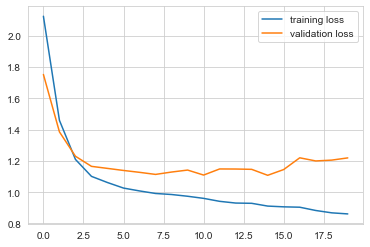

In [18]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

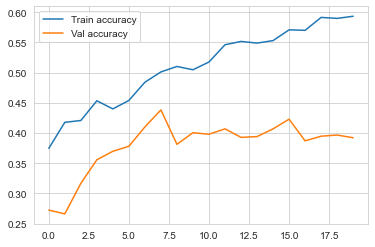

In [19]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [20]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,322,386,38
actual 1,131,247,32
actual 2,123,240,44


In [21]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.2829324169530355

In [22]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.38596491228070173

In [23]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.2948328267477204

In [24]:
rnn_proba = model.predict_proba(test_sequence)

Instructions for updating:
Please use `model.predict()` instead.


In [25]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.755457,0.198036,0.046507
1,0.708320,0.233028,0.058651
2,0.717772,0.210493,0.071735
3,0.797884,0.129674,0.072442
4,0.673776,0.171294,0.154930


In [26]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [27]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-21,6,0,0,1,0.755457,0.198036,0.046507
2014-12-22,0,0,0,1,0.708320,0.233028,0.058651
2014-12-23,1,0,0,1,0.717772,0.210493,0.071735
2014-12-24,2,2,0,0,0.797884,0.129674,0.072442
2014-12-25,3,2,0,0,0.673776,0.171294,0.154930


In [28]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-26,4,2,1,0,0.235559,0.458393,0.306047
2014-12-28,6,2,1,0,0.327128,0.384576,0.288296
2014-12-30,1,2,1,0,0.159935,0.539837,0.300228
2015-01-01,3,2,1,0,0.274280,0.410178,0.315542
2015-01-16,4,2,1,0,0.130958,0.570149,0.298893


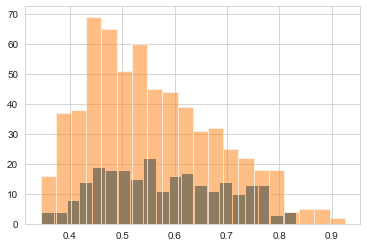

In [29]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [30]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-29,0,2,2,1,0.244579,0.331311,0.424110
2014-12-31,2,2,2,1,0.264171,0.312089,0.423740
2015-01-13,1,2,2,1,0.311827,0.159865,0.528308
2015-01-14,2,2,2,1,0.179944,0.298852,0.521205
2015-01-15,3,2,2,1,0.219057,0.316463,0.464479


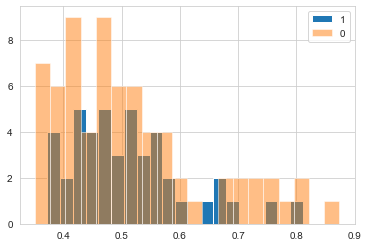

In [31]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [32]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 2

In [33]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [34]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [35]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [36]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [37]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
114/114 [==============================] - 1s 13ms/step - loss: 2.2400 - categorical_accuracy: 0.3778 - val_loss: 1.9786 - val_categorical_accuracy: 0.2746
Epoch 2/50
114/114 [==============================] - 1s 9ms/step - loss: 1.6376 - categorical_accuracy: 0.4261 - val_loss: 1.5549 - val_categorical_accuracy: 0.3316
Epoch 3/50
114/114 [==============================] - 1s 9ms/step - loss: 1.3392 - categorical_accuracy: 0.4543 - val_loss: 1.3393 - val_categorical_accuracy: 0.3630
Epoch 4/50
114/114 [==============================] - 1s 9ms/step - loss: 1.1947 - categorical_accuracy: 0.4562 - val_loss: 1.2442 - val_categorical_accuracy: 0.3809
Epoch 5/50
114/114 [==============================] - 1s 9ms/step - loss: 1.1103 - categorical_accuracy: 0.4700 - val_loss: 1.1851 - val_categorical_accuracy: 0.4065
Epoch 6/50
114/114 [==============================] - 1s 9ms/step - loss: 1.0580 - categorical_accuracy: 0.4947 - val_loss: 1.2035 - val_categorical_accuracy: 0.3553
Epo

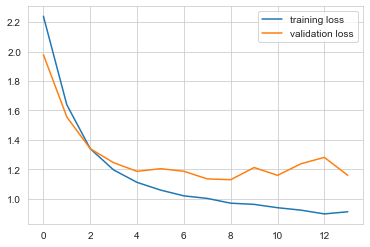

In [38]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

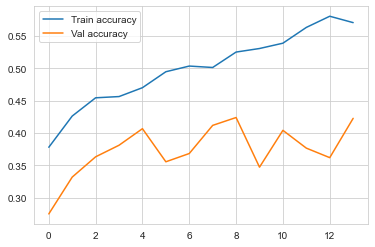

In [39]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [40]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,365,294,86
actual 1,126,210,74
actual 2,139,183,85


In [41]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.3056768558951965

In [42]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.3469387755102041

In [43]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.3165236051502146

In [44]:
rnn_proba = model.predict_proba(test_sequence)

In [45]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.631185,0.238796,0.130020
1,0.486710,0.314603,0.198686
2,0.553197,0.248818,0.197985
3,0.550063,0.169031,0.280906
4,0.204417,0.336398,0.459185


In [46]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [47]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-22,0,0,0,1,0.631185,0.238796,0.130020
2014-12-23,1,0,0,1,0.486710,0.314603,0.198686
2014-12-24,2,2,0,0,0.553197,0.248818,0.197985
2014-12-25,3,2,0,0,0.550063,0.169031,0.280906
2014-12-26,4,2,2,1,0.204417,0.336398,0.459185


In [48]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-01-18,6,2,1,0,0.101902,0.465119,0.432978
2015-01-19,0,2,1,0,0.075133,0.473633,0.451233
2015-01-25,6,1,1,1,0.043244,0.628997,0.327759
2015-01-26,0,1,1,1,0.014031,0.716496,0.269473
2015-01-27,1,1,1,1,0.010599,0.526961,0.462440


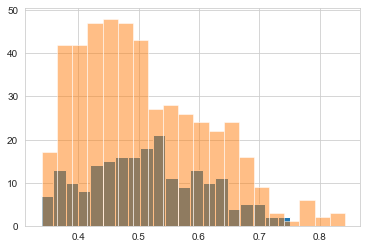

In [49]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [50]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-26,4,2,2,1,0.204417,0.336398,0.459185
2014-12-28,6,2,2,1,0.099050,0.392439,0.508512
2014-12-29,0,2,2,1,0.139932,0.240353,0.619715
2014-12-30,1,2,2,1,0.106889,0.350479,0.542632
2014-12-31,2,2,2,1,0.151163,0.251911,0.596926


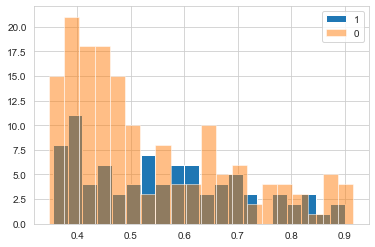

In [51]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [52]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 3

In [53]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [54]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [55]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [56]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [57]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
114/114 [==============================] - 2s 18ms/step - loss: 2.2690 - categorical_accuracy: 0.3853 - val_loss: 2.0766 - val_categorical_accuracy: 0.2864
Epoch 2/50
114/114 [==============================] - 1s 13ms/step - loss: 1.6835 - categorical_accuracy: 0.4276 - val_loss: 1.5989 - val_categorical_accuracy: 0.3165
Epoch 3/50
114/114 [==============================] - 1s 13ms/step - loss: 1.3743 - categorical_accuracy: 0.4723 - val_loss: 1.3748 - val_categorical_accuracy: 0.3543
Epoch 4/50
114/114 [==============================] - 1s 13ms/step - loss: 1.2109 - categorical_accuracy: 0.4684 - val_loss: 1.3324 - val_categorical_accuracy: 0.3453
Epoch 5/50
114/114 [==============================] - 1s 13ms/step - loss: 1.1240 - categorical_accuracy: 0.4761 - val_loss: 1.3499 - val_categorical_accuracy: 0.2793
Epoch 6/50
114/114 [==============================] - 1s 13ms/step - loss: 1.0752 - categorical_accuracy: 0.4789 - val_loss: 1.2827 - val_categorical_accuracy: 0.307

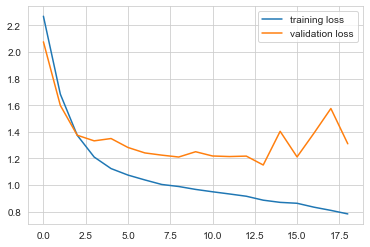

In [58]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

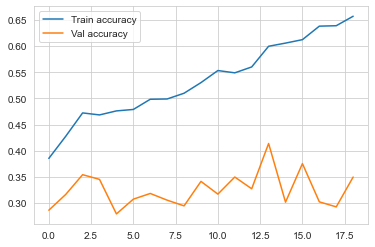

In [59]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [60]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,220,455,69
actual 1,94,264,52
actual 2,90,255,62


In [61]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.27104722792607805

In [62]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.33879781420765026

In [63]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.2817631806395851

In [64]:
rnn_proba = model.predict_proba(test_sequence)

In [65]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.734741,0.110984,0.154274
1,0.453602,0.325841,0.220557
2,0.436265,0.328803,0.234932
3,0.209325,0.511981,0.278694
4,0.150768,0.568107,0.281125


In [66]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [67]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-23,1,0,0,1,0.734741,0.110984,0.154274
2014-12-24,2,2,0,0,0.453602,0.325841,0.220557
2014-12-25,3,2,0,0,0.436265,0.328803,0.234932
2014-12-26,4,2,1,0,0.209325,0.511981,0.278694
2014-12-28,6,2,1,0,0.150768,0.568107,0.281125


In [68]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-26,4,2,1,0,0.209325,0.511981,0.278694
2014-12-28,6,2,1,0,0.150768,0.568107,0.281125
2014-12-29,0,2,1,0,0.152424,0.519642,0.327934
2014-12-30,1,2,1,0,0.139062,0.496836,0.364102
2014-12-31,2,2,1,0,0.116830,0.457235,0.425935


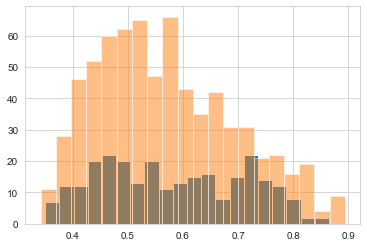

In [69]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [70]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-01-02,4,2,2,1,0.193793,0.340188,0.466019
2015-01-04,6,2,2,1,0.330479,0.306887,0.362634
2015-01-12,0,2,2,1,0.270753,0.343782,0.385465
2015-01-13,1,2,2,1,0.282717,0.266765,0.450518
2015-01-14,2,2,2,1,0.201787,0.347152,0.451062


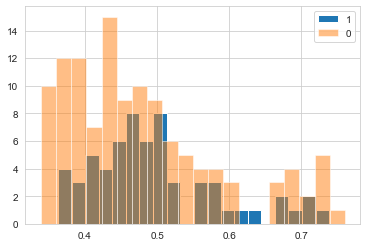

In [71]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [72]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 4

In [73]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [74]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [75]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [76]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [77]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
114/114 [==============================] - 2s 21ms/step - loss: 2.3226 - categorical_accuracy: 0.3942 - val_loss: 2.1139 - val_categorical_accuracy: 0.2750
Epoch 2/50
114/114 [==============================] - 2s 16ms/step - loss: 1.7727 - categorical_accuracy: 0.4483 - val_loss: 1.6928 - val_categorical_accuracy: 0.3474
Epoch 3/50
114/114 [==============================] - 2s 16ms/step - loss: 1.4659 - categorical_accuracy: 0.4738 - val_loss: 1.4723 - val_categorical_accuracy: 0.3288
Epoch 4/50
114/114 [==============================] - 2s 16ms/step - loss: 1.2731 - categorical_accuracy: 0.5023 - val_loss: 1.3762 - val_categorical_accuracy: 0.3583
Epoch 5/50
114/114 [==============================] - 2s 17ms/step - loss: 1.1828 - categorical_accuracy: 0.4650 - val_loss: 1.2567 - val_categorical_accuracy: 0.3821
Epoch 6/50
114/114 [==============================] - 2s 17ms/step - loss: 1.1019 - categorical_accuracy: 0.4900 - val_loss: 1.1920 - val_categorical_accuracy: 0.430

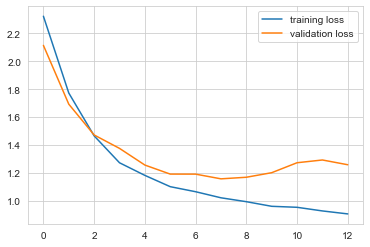

In [78]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

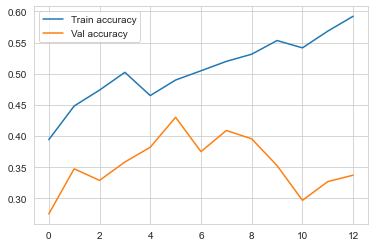

In [79]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [80]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,191,471,81
actual 1,61,277,72
actual 2,58,291,58


In [81]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.2666025024061598

In [82]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.27488151658767773

In [83]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.268

In [84]:
rnn_proba = model.predict_proba(test_sequence)

In [85]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.512964,0.310857,0.176178
1,0.486486,0.316880,0.196634
2,0.377348,0.378709,0.243943
3,0.257030,0.477203,0.265767
4,0.182377,0.489730,0.327893


In [86]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [87]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-24,2,2,0,0,0.512964,0.310857,0.176178
2014-12-25,3,2,0,0,0.486486,0.316880,0.196634
2014-12-26,4,2,1,0,0.377348,0.378709,0.243943
2014-12-28,6,2,1,0,0.257030,0.477203,0.265767
2014-12-29,0,2,1,0,0.182377,0.489730,0.327893


In [88]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-26,4,2,1,0,0.377348,0.378709,0.243943
2014-12-28,6,2,1,0,0.257030,0.477203,0.265767
2014-12-29,0,2,1,0,0.182377,0.489730,0.327893
2014-12-30,1,2,1,0,0.145516,0.518817,0.335667
2014-12-31,2,2,1,0,0.148785,0.464056,0.387159


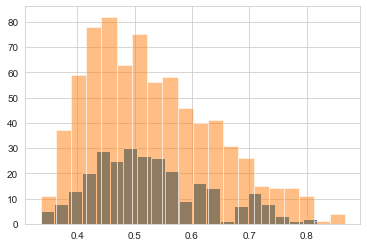

In [89]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [90]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-01-12,0,2,2,1,0.161749,0.345821,0.492431
2015-01-13,1,2,2,1,0.154958,0.301388,0.543653
2015-01-14,2,2,2,1,0.143450,0.335603,0.520947
2015-01-15,3,2,2,1,0.131575,0.373092,0.495334
2015-01-21,2,2,2,1,0.075621,0.385926,0.538453


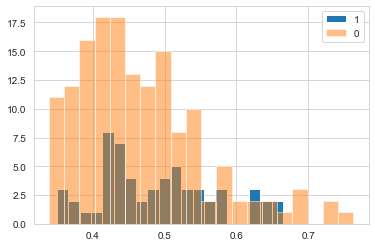

In [91]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [92]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 5

In [93]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [94]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [95]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [96]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [97]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
114/114 [==============================] - 3s 25ms/step - loss: 2.3462 - categorical_accuracy: 0.3583 - val_loss: 2.0428 - val_categorical_accuracy: 0.4157
Epoch 2/50
114/114 [==============================] - 2s 20ms/step - loss: 1.7894 - categorical_accuracy: 0.4231 - val_loss: 1.7102 - val_categorical_accuracy: 0.3566
Epoch 3/50
114/114 [==============================] - 2s 20ms/step - loss: 1.4717 - categorical_accuracy: 0.4731 - val_loss: 1.4560 - val_categorical_accuracy: 0.4092
Epoch 4/50
114/114 [==============================] - 2s 19ms/step - loss: 1.2931 - categorical_accuracy: 0.4703 - val_loss: 1.3177 - val_categorical_accuracy: 0.4259
Epoch 5/50
114/114 [==============================] - 2s 20ms/step - loss: 1.1850 - categorical_accuracy: 0.4975 - val_loss: 1.2638 - val_categorical_accuracy: 0.3894
Epoch 6/50
114/114 [==============================] - 2s 20ms/step - loss: 1.1000 - categorical_accuracy: 0.5096 - val_loss: 1.2551 - val_categorical_accuracy: 0.365

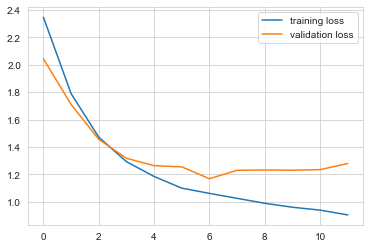

In [98]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

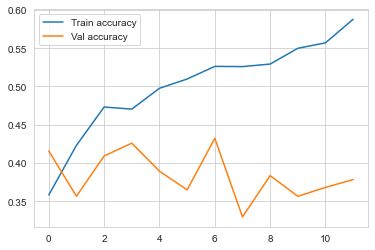

In [99]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [100]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,278,433,32
actual 1,108,252,50
actual 2,80,266,60


In [101]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.26498422712933756

In [102]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.4225352112676056

In [103]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.28545288197621227

In [104]:
rnn_proba = model.predict_proba(test_sequence)

In [105]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.549119,0.222387,0.228494
1,0.316364,0.319530,0.364106
2,0.219539,0.376365,0.404096
3,0.191057,0.391747,0.417197
4,0.182206,0.410645,0.407149


In [106]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [107]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-25,3,2,0,0,0.549119,0.222387,0.228494
2014-12-26,4,2,2,1,0.316364,0.319530,0.364106
2014-12-28,6,2,2,1,0.219539,0.376365,0.404096
2014-12-29,0,2,2,1,0.191057,0.391747,0.417197
2014-12-30,1,2,1,0,0.182206,0.410645,0.407149


In [108]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-30,1,2,1,0,0.182206,0.410645,0.407149
2015-01-18,6,2,1,0,0.108770,0.474905,0.416324
2015-01-19,0,2,1,0,0.076845,0.479805,0.443350
2015-01-23,4,1,1,1,0.086394,0.492687,0.420919
2015-01-25,6,1,1,1,0.057170,0.617412,0.325418


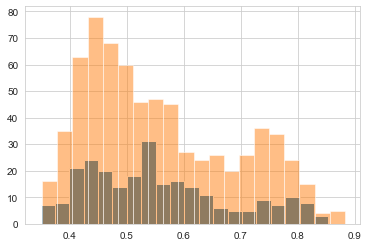

In [109]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [110]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-26,4,2,2,1,0.316364,0.319530,0.364106
2014-12-28,6,2,2,1,0.219539,0.376365,0.404096
2014-12-29,0,2,2,1,0.191057,0.391747,0.417197
2014-12-31,2,2,2,1,0.190255,0.364560,0.445185
2015-01-01,3,2,2,1,0.218292,0.339165,0.442543


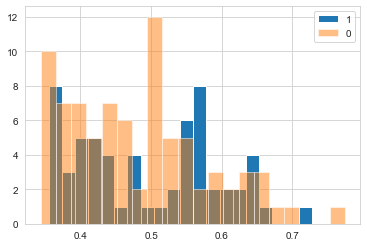

In [111]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [112]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 6

In [113]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [114]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [115]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [116]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [117]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
114/114 [==============================] - 3s 28ms/step - loss: 2.3372 - categorical_accuracy: 0.3930 - val_loss: 2.1474 - val_categorical_accuracy: 0.3081
Epoch 2/50
114/114 [==============================] - 3s 22ms/step - loss: 1.8175 - categorical_accuracy: 0.4180 - val_loss: 1.7367 - val_categorical_accuracy: 0.3639
Epoch 3/50
114/114 [==============================] - 3s 22ms/step - loss: 1.5152 - categorical_accuracy: 0.4567 - val_loss: 1.5176 - val_categorical_accuracy: 0.3870
Epoch 4/50
114/114 [==============================] - 3s 22ms/step - loss: 1.3135 - categorical_accuracy: 0.4999 - val_loss: 1.3217 - val_categorical_accuracy: 0.4576
Epoch 5/50
114/114 [==============================] - 3s 23ms/step - loss: 1.2012 - categorical_accuracy: 0.4864 - val_loss: 1.3298 - val_categorical_accuracy: 0.3607
Epoch 6/50
114/114 [==============================] - 3s 22ms/step - loss: 1.1258 - categorical_accuracy: 0.4900 - val_loss: 1.2774 - val_categorical_accuracy: 0.353

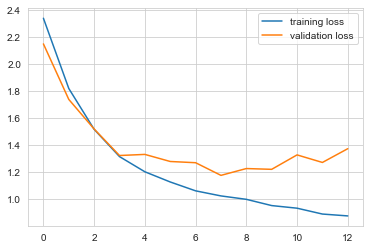

In [118]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

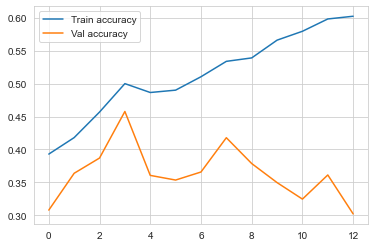

In [119]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [120]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,88,485,170
actual 1,40,259,111
actual 2,32,249,124


In [121]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.2608257804632427

In [122]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.30617283950617286

In [123]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.2739628040057225

In [124]:
rnn_proba = model.predict_proba(test_sequence)

In [125]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.156783,0.461514,0.381702
1,0.086194,0.484259,0.429547
2,0.089321,0.427380,0.483300
3,0.103278,0.421884,0.474838
4,0.118783,0.350815,0.530402


In [126]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [127]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-26,4,2,1,0,0.156783,0.461514,0.381702
2014-12-28,6,2,1,0,0.086194,0.484259,0.429547
2014-12-29,0,2,2,1,0.089321,0.427380,0.483300
2014-12-30,1,2,2,1,0.103278,0.421884,0.474838
2014-12-31,2,2,2,1,0.118783,0.350815,0.530402


In [128]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-26,4,2,1,0,0.156783,0.461514,0.381702
2014-12-28,6,2,1,0,0.086194,0.484259,0.429547
2015-01-05,0,2,1,0,0.162536,0.474147,0.363318
2015-01-06,1,2,1,0,0.144841,0.433997,0.421162
2015-01-07,2,2,1,0,0.143743,0.467737,0.388520


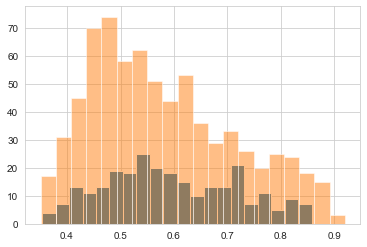

In [129]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [130]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-29,0,2,2,1,0.089321,0.427380,0.483300
2014-12-30,1,2,2,1,0.103278,0.421884,0.474838
2014-12-31,2,2,2,1,0.118783,0.350815,0.530402
2015-01-01,3,2,2,1,0.115303,0.356263,0.528434
2015-01-02,4,2,2,1,0.152534,0.363663,0.483803


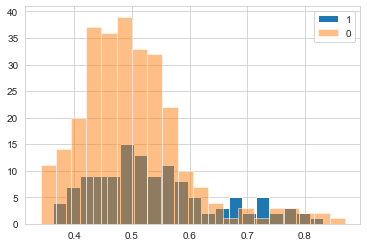

In [131]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()

### un-randomized train set

In [132]:
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
series_length = 7

In [133]:
# Create training sequences
train_sequence = TimeseriesGenerator(X_train_ss, y_train_cat, 
                                     length=series_length, 
                                     batch_size=32)

In [134]:
# Create test sequences
test_sequence = TimeseriesGenerator(X_test_ss, y_test_cat, 
                                    length=series_length, 
                                    batch_size=32)

In [135]:
model = Sequential()
model.add(GRU(X_train_ss.shape[1], input_shape=(series_length,
                                                X_train_ss.shape[1]), 
                                                return_sequences=True))
model.add(GRU(X_train_ss.shape[1]))

model.add(Dense(X_train_ss.shape[1], activation='relu', 
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(3, activation='softmax'))

In [136]:
model.compile(optimizer=Adam(lr = .0005), 
              loss = 'categorical_crossentropy', 
              metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')


In [137]:
%%time
history = model.fit_generator(train_sequence, 
                              validation_data=test_sequence,
                              epochs=50,
                              verbose=1,
                              callbacks=[early_stop])

Epoch 1/50
114/114 [==============================] - 3s 30ms/step - loss: 2.3699 - categorical_accuracy: 0.3692 - val_loss: 2.1502 - val_categorical_accuracy: 0.3308
Epoch 2/50
114/114 [==============================] - 3s 24ms/step - loss: 1.8239 - categorical_accuracy: 0.4442 - val_loss: 1.7513 - val_categorical_accuracy: 0.3205
Epoch 3/50
114/114 [==============================] - 3s 24ms/step - loss: 1.5063 - categorical_accuracy: 0.4703 - val_loss: 1.5241 - val_categorical_accuracy: 0.3924
Epoch 4/50
114/114 [==============================] - 3s 25ms/step - loss: 1.3213 - categorical_accuracy: 0.4865 - val_loss: 1.4131 - val_categorical_accuracy: 0.3603
Epoch 5/50
114/114 [==============================] - 3s 25ms/step - loss: 1.2067 - categorical_accuracy: 0.4860 - val_loss: 1.3198 - val_categorical_accuracy: 0.3468
Epoch 6/50
114/114 [==============================] - 3s 25ms/step - loss: 1.1200 - categorical_accuracy: 0.5148 - val_loss: 1.2965 - val_categorical_accuracy: 0.351

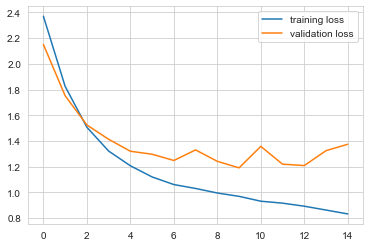

In [138]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

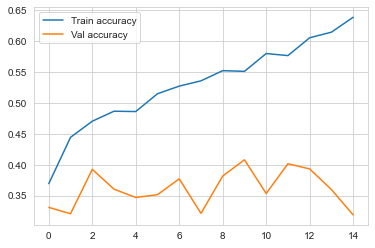

In [139]:
plt.plot(history.history['categorical_accuracy'], label='Train accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val accuracy')
plt.legend();

In [140]:
rnn_pred = np.argmax(model.predict(test_sequence), axis=-1)
cm = confusion_matrix(y_test[series_length:], rnn_pred)
cm_df = pd.DataFrame(cm, columns=['pred 0', 'pred 1', 'pred 2'], index=['actual 0', 'actual 1', 'actual 2'])
cm_df

,pred 0,pred 1,pred 2
actual 0,169,533,41
actual 1,65,290,55
actual 2,91,276,37


In [141]:
cm_df.loc['actual 1'][1]/(cm_df['pred 1'].sum())

0.26387625113739765

In [142]:
cm_df.loc['actual 2'][2]/(cm_df['pred 2'].sum())

0.2781954887218045

In [143]:
(cm_df.loc['actual 1'][1]+cm_df.loc['actual 2'][2])/((cm_df['pred 1'].sum())+(cm_df['pred 2'].sum()))

0.26542207792207795

In [144]:
rnn_proba = model.predict_proba(test_sequence)

In [145]:
rnn_proba = pd.DataFrame(rnn_proba)
rnn_proba.head()

,0,1,2
0,0.116843,0.600286,0.282871
1,0.119701,0.556765,0.323533
2,0.133970,0.562676,0.303354
3,0.151502,0.507625,0.340873
4,0.164153,0.498421,0.337426


In [146]:
results_compare = pd.DataFrame(X_test["day_of_wk"][series_length:])
results_compare['results'] = pd.DataFrame(y_test[series_length:])
results_compare['pred'] = rnn_pred
results_compare['compare'] = (results_compare['results'] == results_compare['pred']).astype(int)
results_compare['proba_0'] = rnn_proba[0].values
results_compare['proba_1'] = rnn_proba[1].values
results_compare['proba_2'] = rnn_proba[2].values

In [147]:
results_compare.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-28,6,2,1,0,0.116843,0.600286,0.282871
2014-12-29,0,2,1,0,0.119701,0.556765,0.323533
2014-12-30,1,2,1,0,0.133970,0.562676,0.303354
2014-12-31,2,2,1,0,0.151502,0.507625,0.340873
2015-01-01,3,2,1,0,0.164153,0.498421,0.337426


In [148]:
pred_1 = results_compare[results_compare['pred']==1]
pred_1.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2014-12-28,6,2,1,0,0.116843,0.600286,0.282871
2014-12-29,0,2,1,0,0.119701,0.556765,0.323533
2014-12-30,1,2,1,0,0.133970,0.562676,0.303354
2014-12-31,2,2,1,0,0.151502,0.507625,0.340873
2015-01-01,3,2,1,0,0.164153,0.498421,0.337426


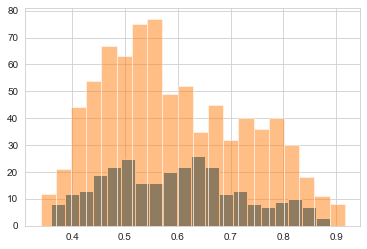

In [149]:
plt.hist(pred_1[pred_1['compare']==1]['proba_1'], label="1", bins=20)
plt.hist(pred_1[pred_1['compare']==0]['proba_1'], alpha = 0.5, label="0", bins=20);

In [150]:
pred_2 = results_compare[results_compare['pred']==2]
pred_2.head()

,day_of_wk,results,pred,compare,proba_0,proba_1,proba_2
2015-01-12,0,2,2,1,0.091466,0.439546,0.468987
2015-01-13,1,2,2,1,0.114109,0.410499,0.475392
2015-01-21,2,2,2,1,0.060067,0.418003,0.521930
2015-01-22,3,2,2,1,0.104335,0.264382,0.631283
2015-01-28,2,1,2,0,0.044783,0.345830,0.609387


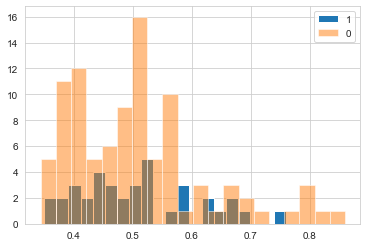

In [151]:
plt.hist(pred_2[pred_2['compare']==1]['proba_2'], label="1", bins =20)
plt.hist(pred_2[pred_2['compare']==0]['proba_2'], alpha = 0.5, label='0', bins =20);

plt.legend()